Neuroimaging cartesian reconstruction
=====================================
Author: Chaithya G R
In this tutorial we will reconstruct an MRI image from the sparse kspace
measurements.
Import neuroimaging data
------------------------
We use the toy datasets available in pysap, more specifically a 2D brain slice
and the non cartesian acquisition scheme.

Package import

In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2
from mri.operators.utils import convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.1     installed
numpy          : >=1.16.4  - required | 1.17.3    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.4.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.0     installed
scikit-learn   : >=0.19.1  - requi

Loading input data and non-cartesian k-space mask

/home/chaithyagr/Codes/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


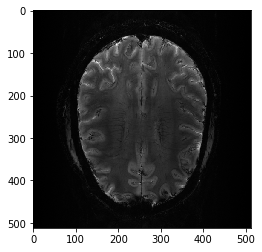

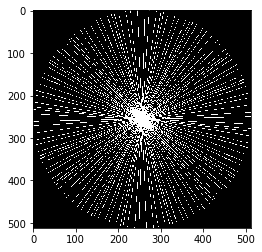

In [2]:
image = get_sample_data('2d-mri')
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, image.shape))
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a radial acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples and the associated observations

In [3]:
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=image.shape,
                             implementation='cpu')
kspace_obs = fourier_op.op(image.data)

In [ ]:
Gridded solution

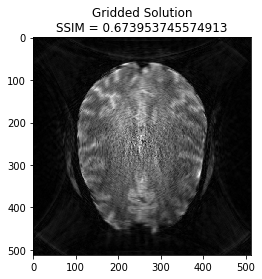

In [4]:
grid_space = np.linspace(-0.5, 0.5, num=image.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, kspace_obs,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, image)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

Setup Reconstruction Operators
------------------------------

Linear Operator : undecimated (bi-) orthogonal transform (three bands per scale) with 4 Scales

In [5]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

Regularizer Operator : SparseThreshold ie L1 Norm. Lambda = 2e-7

In [6]:
regularizer_op = SparseThreshold(Identity(), 6 * 1e-7, thresh_type="soft")

In [ ]:
Setup Single Channel Reconstructor

In [7]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 569.9809425205583
The lipschitz constraint is satisfied


FISTA optimization
------------------

We now want to refine the gridded solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost
Start Reconstruction

 - mu:  6e-07
 - lipschitz constant:  569.9809425205583
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7f5dd8811978> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (2621440,)
----------------------------------------
Starting optimization...
 - final iteration number:  400
 - final log10 cost value:  -6.37209648153608
 - converged:  False
Done.
Execution time:  496.637335  seconds
----------------------------------------


100% (200 of 200) |######################| Elapsed Time: 0:06:37 Time:  0:06:37


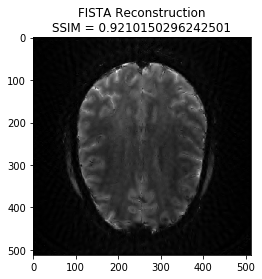

In [9]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()